In [1]:
import numpy as np
import cv2
import random
from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout
from tensorflow.keras import layers

In [2]:
import keras.backend as K

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])



In [8]:
dataset = "Documents/datasetMRST/pres"
data=[]
imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(42)

random.shuffle(imagePaths)
for imagePath in imagePaths:

    image = cv2.imread(imagePath)

    image = cv2.resize(image, (28, 28))

    image = rgb2gray(image)

    data.append(image)
    
data_p = np.array(data, dtype="float") / 255.0


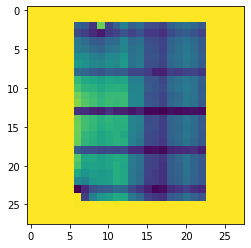

In [9]:
plt.imshow(data_p[1])


In [7]:
data_p[1].shape

(28, 28)

In [8]:
dataset = input("datasetDocuments/datasetMRST/vel")
data=[]
imagePaths = sorted(list(paths.list_images(dataset)))
random.seed(42)

random.shuffle(imagePaths)
for imagePath in imagePaths:

    image = cv2.imread(imagePath)

    image = cv2.resize(image, (28, 28))

    image = rgb2gray(image)

    data.append(image)
    
data_v = np.array(data, dtype="float") / 255.0

Enter the path to velocity datasetDocuments/datasetMRST/vel


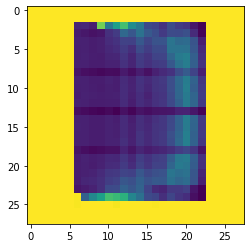

In [9]:
plt.imshow(data_v[1])

In [10]:
data_v[1].shape

(28, 28)

In [11]:
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
encoded = Dense(2, activation='linear')(x)

input_enc = Input(shape=(2,))
d = Dense(64, activation='relu')(input_enc)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model(input_img, encoded, name="encoder")
decoder = keras.Model(input_enc, decoded, name="decoder")
autoencoder = keras.Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.compile(optimizer='adam', loss='mean_squared_error')



In [12]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 108866    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         51152     
Total params: 160,018
Trainable params: 160,018
Non-trainable params: 0
_________________________________________________________________


In [23]:
autoencoder.fit(data_p, data_v,
                epochs=100,
                batch_size=4,
                shuffle=True)

Epoch 1/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 6/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 8/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 9/100
28/28 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 10/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 11/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 12/100
28/28 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 13/100
28/28 [=================

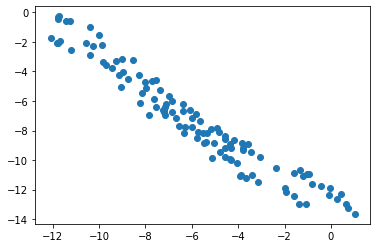

In [24]:
h = encoder.predict(data_p)
a = plt.scatter(h[:, 0], h[:, 1])


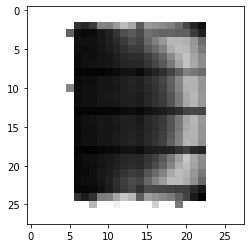

In [26]:
img = decoder.predict(np.expand_dims([0, -14], axis=0))
plt.imshow(img.squeeze(), cmap='gray')

In [28]:
hidden_dim = 2
batch_size = 2 # должно быть кратно 

def dropout_and_batch(x):
  return Dropout(0.3)(BatchNormalization()(x))

input_img = Input((28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x) # подключаем два вектора - среднее и вариацию

def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
  return K.exp(z_log_var / 2) * N + z_mean #формирование вектора скртыого состояни АШ

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var]) #кастомный слой

input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='relu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model(input_img, h, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')
vae = keras.Model(input_img, decoder(encoder(input_img)), name="vae")


def vae_loss(x, y):
  x = K.reshape(x, shape=(batch_size, 28*28))
  y = K.reshape(y, shape=(batch_size, 28*28))
  loss = K.sum(K.square(x-y), axis=-1)
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # Дивергенция Кульбака-Лейблера-показывает расхождение нашей вероятности с нормальной
  return loss + kl_loss



In [29]:

vae.compile(optimizer='adam', loss=vae_loss)

vae.fit(data_p, data_v, epochs=100, batch_size=batch_size, shuffle=True)


Epoch 1/100
55/55 [==============================] - 1s 4ms/step - loss: 152.2169
Epoch 2/100
55/55 [==============================] - 0s 4ms/step - loss: 128.0032
Epoch 3/100
55/55 [==============================] - 0s 4ms/step - loss: 92.9287
Epoch 4/100
55/55 [==============================] - 0s 4ms/step - loss: 50.6775
Epoch 5/100
55/55 [==============================] - 0s 4ms/step - loss: 31.2797
Epoch 6/100
55/55 [==============================] - 0s 4ms/step - loss: 24.4450
Epoch 7/100
55/55 [==============================] - 0s 4ms/step - loss: 21.9758
Epoch 8/100
55/55 [==============================] - 0s 4ms/step - loss: 20.4859
Epoch 9/100
55/55 [==============================] - 0s 4ms/step - loss: 19.9070
Epoch 10/100
55/55 [==============================] - 0s 4ms/step - loss: 18.3468
Epoch 11/100
55/55 [==============================] - 0s 4ms/step - loss: 18.1841
Epoch 12/100
55/55 [==============================] - 0s 4ms/step - loss: 18.9773
Epoch 13/100
55/55 [===

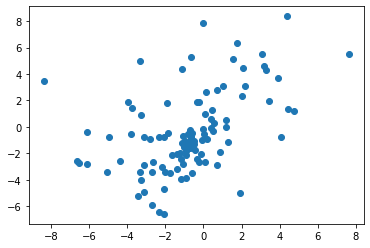

In [30]:
h = encoder.predict(data_p, batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])

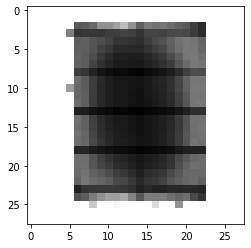

In [38]:
img = decoder.predict(np.expand_dims([0, 0], axis=0))
plt.imshow(img.squeeze(), cmap='gray')

In [13]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [14]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [15]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [16]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [17]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data_p, data_v , epochs=3, batch_size=2)

Epoch 1/3


ValueError: in user code:

    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    <ipython-input-16-373258cf77cd>:22 train_step
        z_mean, z_log_var, z = self.encoder(data)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:204 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer encoder expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(2, 28, 28, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(2, 28, 28, 3) dtype=float32>]


In [13]:
data_p = np.reshape(data_p, (len(data_p), 64, 64, 3))
data_v  = np.reshape(data_v,  (len(data_v),  64, 64, 3))

In [15]:
hidden_dim = 2
batch_size = 2 # должно быть кратно 110

def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))


input_img = Input((28, 28, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(z_log_var / 2) * N + z_mean

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='relu')(d)
d = dropout_and_batch(d)
d = Dense(64*64, activation='sigmoid')(d)
decoded = Reshape((64, 64, 3))(d)

encoder = keras.Model(input_img, h, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')
vae = keras.Model(input_img, decoder(encoder(input_img)), name="vae")



ValueError: total size of new array must be unchanged, input_shape = [4096], output_shape = [64, 64, 3]

In [ ]:

def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return loss + kl_loss



In [ ]:
vae.compile(optimizer='adam', loss=vae_loss)

vae.fit(data_p, data_v epochs=5, batch_size=batch_size, shuffle=True)




In [ ]:
h = encoder.predict(x_test[:6000], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])


n = 5
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num += 1
        img = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0))
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [51]:
from tensorflow.keras import layers

In [52]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [59]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   896         input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 3136)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [60]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 1, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_46 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 28, 28, 3)         99        
Total params: 64,899
Trainable params: 64,899
Non-trainable params: 0
_______________________________________________________

In [61]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [66]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data_p, epochs=5, batch_size=2)



Epoch 1/5


ValueError: in user code:

    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    <ipython-input-61-373258cf77cd>:22 train_step
        z_mean, z_log_var, z = self.encoder(data)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/hwu/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer encoder: expected shape=(None, 28, 28, 3), found shape=(2, 64, 64, 3)
